# Introduction to Length Optimization in Conformal Prediction 

In this notebook, we will implement and evaluate Conformal Prediction with Length Optimization (CPL) approach. We will compare its performance with the state-of-the-art method BatchGCP [Jung et al. (2023)] and the Split Conformal method. The task is a synthetic regression task designed to test the effectiveness of these algorithms.

This notebook can be easily modified for any other real-world dataset and task. We are showcasing the performance of CPL on this simple task as a guideline to help practitioners and researchers implement and use CPL in their own work.

## Synthetic Regression Task Setup

We use a synthetic regression task similar to the one described in Jung et al. (2023) to compare CPL with BatchGCP. The covariate $ X = (X_1, \cdots, X_{20}) $ is a vector in $ \mathbb{R}^{20} $. The data distribution is defined as follows:

- The first ten coordinates of \( X \) are independent uniform binary variables.
- The remaining 10 coordinates of \( X \) are i.i.d. Gaussian variables.

The label \( y \) is generated according to the following equation:
$$
y = \langle \theta, X \rangle + \epsilon_X,
$$
where $ \epsilon_X $ is a zero-mean Gaussian noise with variance
$$
\sigma_X^2 = 1 + \sum_{i=1}^{10}iX_i + \left(40 \cdot \mathbb{1}\left[\sum_{i=11}^{20}X_i \geq 0\right] - 20\right).
$$

We generate three datasets for this experiment:
- **Training data**: 150,000 samples
- **Calibration data**: 100,000 samples
- **Test data**: 200,000 samples


## Group Definition

We define 20 overlapping groups based on the ten binary components of \( X \):
- For each \( i \) in 1 to 10, Group \( 2i-1 \) corresponds to $ X_i = 0 $.
- Group \( 2i \) corresponds to $ X_i = 1 $.

Both BatchGCP and CPL are implemented to provide group-conditional coverage for these groups.

Additionally, we include the Split Conformal method as the third baseline.

In the following cells, we will implement CPL and evaluate its performance compared to BatchGCP and Split Conformal.

**Note:** This notebook is designed to be flexible and can be adapted to other real-world datasets and tasks. The synthetic regression task here serves as a simple demonstration of CPL's capabilities, providing a guideline for researchers and practitioners to implement and utilize CPL in their own projects.


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [54]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Data Generation

In this section, we will generate the synthetic dataset based on the setup described earlier. The dataset will include binary and continuous features, and the labels will be generated according to the above-mentioned equations. This synthetic dataset allows us to evaluate the performance of the CPL algorithm in a controlled environment.

For practical applications, you can load or generate your own dataset depending on your specific task. The synthetic dataset here is created for demonstration purposes and follows the described equations. You can modify the dimensions of the data and the number of training, calibration, and test samples to explore different data regimes.

The following code defines a `SyntheticLinearRegressionDataset` class that generates the synthetic data:

In [56]:
class SyntheticLinearRegressionDataset(Dataset):
    def __init__(self, n_samples, n_binary=10, n_continuous=90, sigma_x=1.0, sigma=1.0):
        # Feature generation
        self.binary_features = np.random.randint(0, 2, (n_samples, n_binary))
        self.continuous_features = np.random.normal(0, sigma_x, (n_samples, n_continuous))
        self.features = np.hstack((self.binary_features, self.continuous_features))

        self.theta = np.ones(n_binary + n_continuous)/np.sqrt(n_binary + n_continuous)
        self.zeta = np.ones(n_continuous)
    
        # Compute label
        noise_factors = np.arange(1, n_binary+1)
        self.noise_std_dev = np.sqrt(np.abs(sigma**2 + np.dot(self.binary_features, noise_factors) + np.where(np.dot(self.continuous_features, self.zeta)<0, -20, 20)))
        self.noise = np.array([np.random.normal(0, noise_std) for noise_std in self.noise_std_dev])
        self.labels = np.dot(self.features, self.theta) + self.noise

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return torch.FloatTensor(self.features[idx]), torch.FloatTensor([self.labels[idx]])

# Compute S function


n_binary = 10
n_continuous = 10

d = n_binary + n_continuous
sigma_x = 1/np.sqrt(n_continuous)
sigma = 1

train = SyntheticLinearRegressionDataset(150000, n_binary, n_continuous, sigma_x, sigma)
X_train = torch.stack([features for features, _ in train]).to(device)
Y_train = torch.stack([labels for _, labels in train]).to(device)

calibration = SyntheticLinearRegressionDataset(100000, n_binary, n_continuous, sigma_x, sigma)
X_cal = torch.stack([features for features, _ in calibration]).to(device)
Y_cal = torch.stack([labels for _, labels in calibration]).to(device)

test = SyntheticLinearRegressionDataset(200000, n_binary, n_continuous, sigma_x, sigma)
X_test = torch.stack([features for features, _ in test]).to(device)
Y_test = torch.stack([labels for _, labels in test]).to(device)

## Training the Predictive Model

In this section, we will train a predictive model for the synthetic regression task. The model we use here is a simple linear regression, where we calculate the regression coefficients using the pseudoinverse of the feature matrix. This allows us to predict the label \( y \) based on the input features \( X \).

In general, you should build and train (or load) the predictive model that is most suitable for your specific task, which you aim to quantify its uncertainty.

The following code snippet trains a linear regression model:


In [57]:
beta = torch.pinverse(X_train.T @ X_train) @ X_train.T @ Y_train

## Computing the Conformity Scores

Now we enter the Conformal Prediction pipeline. Before this, we followed the routine machine learning pipeline, which included data generation and training the predictive model. In this step, we compute the conformity scores, which are essential for the Conformal Prediction framework.

For regression tasks, we often use residuals as the conformity scores. Residuals measure the difference between the actual labels and the predicted labels, providing an indication of how well the model's predictions conform to the observed data.

In general, you should use a conformity score that is tailored to the task at hand. There is a large and growing body of literature on designing better conformity scores for various tasks. You can look at Awsome Conformal Prediction github for a collection of references.

The following code snippet calculates the conformity scores using the residuals:

In [58]:
def compute_S(X, Y, beta):
    product= (X @ beta).squeeze()
    Y=Y.squeeze()
    return torch.abs(Y - product)

S_cal = compute_S(X_cal, Y_cal, beta)
S_test = compute_S(X_test, Y_test, beta)

## Conformal Prediction with Length-Optimization (CPL)

In the following cells, we implement our main algorithm: Conformal Prediction with Length-Optimization (CPL). This algorithm is designed to construct tight prediction sets that are conditionally valid with respect to a given class of functions.

### Smoothing Technique

We use a smoothing technique using the Gaussian error function. This allows us to create a continuous and differentiable approximation of the indicator function, which appears in CPL optimization objective.

The smoothed indicator function is defined as:
$$
\tilde{1}(a, b) = \frac{1}{2} \left( 1 + \text{erf}\left( \frac{a - b}{\sqrt{2}\sigma} \right) \right),
$$
where $\text{erf}(x)$ is the Gaussian error function, and $\sigma$ controls the smoothness of the transition between 0 and 1. As $\sigma$ approaches zero, $\tilde{1}(a, b)$ converges to the original indicator function.

The smoothed version of our objective function is:
$$
\tilde{g}_{\alpha,n}(f, h) = \frac{1}{n}\sum_{i=1}^n\left[f(x_i)\bigg\{\tilde{1}(S(x_i, y_i), h(x_i)) - (1-\alpha)\bigg\}\right] - \frac{1}{n}\sum_{i=1}^n \int_{\mathcal{Y}}\tilde{1}(S(x_i, y), h(x_i)) dy.
$$

where $\{(x_i, y_i)\}$ is the collection of calibration data.

### CPL Algorithm

The CPL algorithm aims to minimize the length of the prediction sets while ensuring conditional validity. The algorithm is based on a gradient descent-ascent approach, iteratively optimizing over the classes $\mathcal{F} $ and $\mathcal{H}$.

**Inputs:**
- Miscoverage level $\alpha$
- Conditional coverage requirements $\mathcal{F}$
- Conformity score $S$
- Class of functions $\mathcal{H}$

**Objective:**
$$
\begin{aligned}
&\underset{f \in \mathcal{F}}{\text{Minimize}}\; \underset{h \in \mathcal{H}}{\text{Maximize}} \; \tilde{g}_{\alpha,n}(f, h).
\end{aligned}
$$

**Algorithm Steps:**
1. Initialize functions $ f \in \mathcal{F} $ and $ h \in \mathcal{H}$ .
2. Repeat until convergence:
    - Perform a few iterations (e.g., Gradient Descent (GD) steps) on $ h $ to maximize $\tilde{g}_{\alpha,n}(f, h)$.
    - Perform a few iterations (e.g., GD steps) on $ f $ to minimize $\tilde{g}_{\alpha,n}(f, h)$.
3. Set $ f_{\rm CPL}^* $ to the optimized $f $.
4. Set $ h_{\rm CPL}^* $ to the optimized $ h $.
5. Define the prediction set $ C_{\rm CPL}^*(x) = \{y \in \mathcal{Y} \;|\; S(x,y) \leq h_{\rm CPL}^*(x)\} $.

In practice, the machine learning models, such as neural networks, are parametric (e.g., $ h_\theta $, where $\theta$ is the set of parameters). Performing the iteration on $ h $ involves updating $\theta$. Similarly, for $ f $, in the case of group-conditional, performing the iteration involves updating the parameters associated to each of the groups.

The following code snippet implements the class $\mathcal{H}$ (in general you can pick a model which works best in your task):


In [59]:
class SimpleNN(nn.Module):
    def __init__(self, n_binary, n_continuous, embedding_dim, dropout_rate=0.1):
        super(SimpleNN, self).__init__()
        self.n_binary = n_binary
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(2, embedding_dim)  # Embedding for binary variables

        # Calculate the total input dimension after embedding binary variables
        total_input_dim = n_binary * embedding_dim + n_continuous
        
        self.layer1 = nn.Linear(total_input_dim, 20)
        self.norm1 = nn.LayerNorm(20)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_rate)  # Dropout layer after the first ReLU

        self.layer2 = nn.Linear(20, 10)
        self.norm2 = nn.LayerNorm(10)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout_rate)  # Dropout layer after the second ReLU

        self.layer3 = nn.Linear(10, 1)

    def forward(self, x):
        # Split the input into binary and continuous parts
        x_binary = x[:, :self.n_binary].long()  # Assuming the first n_binary are binary
        x_continuous = x[:, self.n_binary:]     # The rest are continuous

        # Embedding the binary variables
        x_binary = self.embedding(x_binary)    # Shape [batch_size, n_binary, embedding_dim]
        x_binary = x_binary.view(x_binary.shape[0], -1)  # Flatten the embeddings

        # Concatenate the embedded binary variables with the continuous variables
        x = torch.cat([x_binary, x_continuous], dim=1)

        # Pass through the network
        x = self.layer1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.dropout1(x)  # Apply dropout after the first ReLU

        x = self.layer2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        x = self.dropout2(x)  # Apply dropout after the second ReLU

        x = self.layer3(x)
        return x.squeeze()

## Optimization Modules for CPL

In this section, we implement the descent and ascent parts of the CPL algorithm as two separate modules. These modules handle the optimization of the functions \( h \) and \( f \), respectively, using gradient descent ascent techniques.


In [60]:
def maximize_for_h(optimizer_h, X, S, h, lambda_tensor, lambda_marginal, alpha, sigma = 0.1):
    h.train()
    optimizer_h.zero_grad()
    h_x = h(X)
    indicator_approx = 0.5 * (1 + torch.erf((-S + h_x) / (sigma * np.sqrt(2))))
    sum_lambda = torch.sum(lambda_tensor * X[:, :lambda_tensor.shape[0]] + lambda_marginal, axis=1)
    product = sum_lambda * (indicator_approx - (1.0 - alpha))
    h_x_positive = torch.clamp(h_x, min=0)
    loss_h = - torch.mean(product - h_x_positive)
    loss_h.backward()
    optimizer_h.step()

    return loss_h.item()

def minimize_for_f(optimizer_lambda, X, S, h, lambda_tensor, lambda_marginal, alpha, sigma = 0.1):
    optimizer_lambda.zero_grad()
    h_x = h(X)
    indicator_approx = (S <= h_x).float()
    sum_lambda = torch.sum(lambda_tensor * X[:, :lambda_tensor.shape[0]] + lambda_marginal, axis=1)
    product = sum_lambda * (indicator_approx - (1.0 - alpha))
    h_x_positive = torch.clamp(h_x, min=0)
    loss_lambda = torch.mean(product - h_x_positive)
    loss_lambda.backward()
    optimizer_lambda.step()

    return lambda_tensor, lambda_marginal, loss_lambda.item()

## Running the CPL Algorithm

In this section, we will run the Conformal Prediction with Length-Optimization (CPL) algorithm. The CPL algorithm involves solving a minimax optimization problem. In general, solving minimax problems usually require careful tuning of hyperparameters and other heuristics to ensure robust performance. This includes avoiding common issues such as exploding or vanishing gradients.

In general, solving minimax optimization problems requires:
- Careful tuning of learning rates.
- Appropriate scheduling of optimization steps.
- Balancing the number of descent and ascent steps.

Here, we have implemented a very simple and plain version of the CPL algorithm without extensive fine-tuning of the learning rates or the number of descent and ascent steps. Despite this, we will show the significant improvement of our framework in terms of length efficiency over state-of-the-art (SOTA) methods in the following evaluations.

For practical applications, it is essential to go through a pipeline of fine-tuning to get the best performance out of CPL, similar to almost all machine learning-based algorithms in the literature.

The following code splits the calibration data, initializes the required parameters, and runs the CPL optimization process:



In [61]:
split_idx = int(0.7 * X_cal.shape[0])

# Split the tensors
X1 = X_cal[:split_idx]
S1 = S_cal[:split_idx]
X2 = X_cal[split_idx:]
S2 = S_cal[split_idx:]

lambda_tensor = torch.tensor([5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0], requires_grad = True, device=device)
lambda_marginal = torch.tensor([5.0], requires_grad = True, device=device)
alpha=0.1

optimizer_lambda = optim.Adam([lambda_tensor] +[lambda_marginal], lr=1)

for t in range(60):
    if t%1000 == 15:
        optimizer_lambda = optim.Adam([lambda_tensor] +[lambda_marginal], lr=0.5)
    if t%1000 == 30:
        optimizer_lambda = optim.Adam([lambda_tensor] +[lambda_marginal], lr=0.01)
        
    h = SimpleNN(n_binary, n_continuous, 4).to(device)
    optimizer_h = optim.Adam(h.parameters(), lr=0.01)
    
    for epoch in range(2000):
        loss_h = maximize_for_h(optimizer_h, X1, S1, h, lambda_tensor, lambda_marginal, alpha = 0.1, sigma = 0.1)
        if epoch%1000==500:
            optimizer_h = optim.Adam(h.parameters(), lr=0.001)
        if epoch%2000==1000:
            optimizer_h = optim.Adam(h.parameters(), lr=0.0002)
    for epoch in range(1):
        lambda_tensor, lambda_marginal, loss_lambda = minimize_for_lambda(optimizer_lambda, X2, S2, h, lambda_tensor, lambda_marginal, alpha = 0.1, sigma = 0.1)
    
    


In the next cell we implement BatchGCP.

In [84]:
import torch
import torch.optim as optim
device = 'cpu'
X_cal = X_cal.to(device)
S_cal = S_cal.to(device)
# Pinball Loss
def pinball_loss(q, s, tau):
    return torch.where(s >= q, tau * (s - q), (1 - tau) * (q - s))

# Definitions and initializations
theta_tensor = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], requires_grad=True).to(device)
theta_marginal = torch.tensor([1.0], requires_grad=True).to(device)

optimizer = optim.Adam([theta_tensor, theta_marginal], lr=0.01)

for epoch in range(5000):
    optimizer.zero_grad()

    # Simplified example operation
    sum_theta = torch.sum(theta_tensor * X_cal[:, :theta_tensor.shape[0]] + theta_marginal, axis=1)

    loss = pinball_loss(sum_theta, S_cal, 0.9).mean()

    loss.backward()
    optimizer.step()


Implementing split conformal prediction.

In [78]:
size = S_cal.shape[0]
q_HS = torch.quantile(S_cal, 0.9*(size+1)/size)

condition = (S_test <= q_HS).float()  
value = condition.mean().item() 

print(f'Quantile (q): {q_HS.item():.4f}')


Quantile (q): 9.1933


## Plots

Here we compare the CPL with BatchGCP and Split conformal solutions through plotting their group-conditional coverage and length performance. To get the plots reported in our paper, one has to evaluate the performance of all algorithms over 100 trials and look at the averaged plots, Here we only plot one instance. As a result both BathcGCP and CPL does not have perfect coverage per group, yet still correcting the severe over covering and under covering of the Split Conformal solution. 

Looking at the length plots, one can observe that CPL can significantly improve the length performance by learning the hidden features in the data.

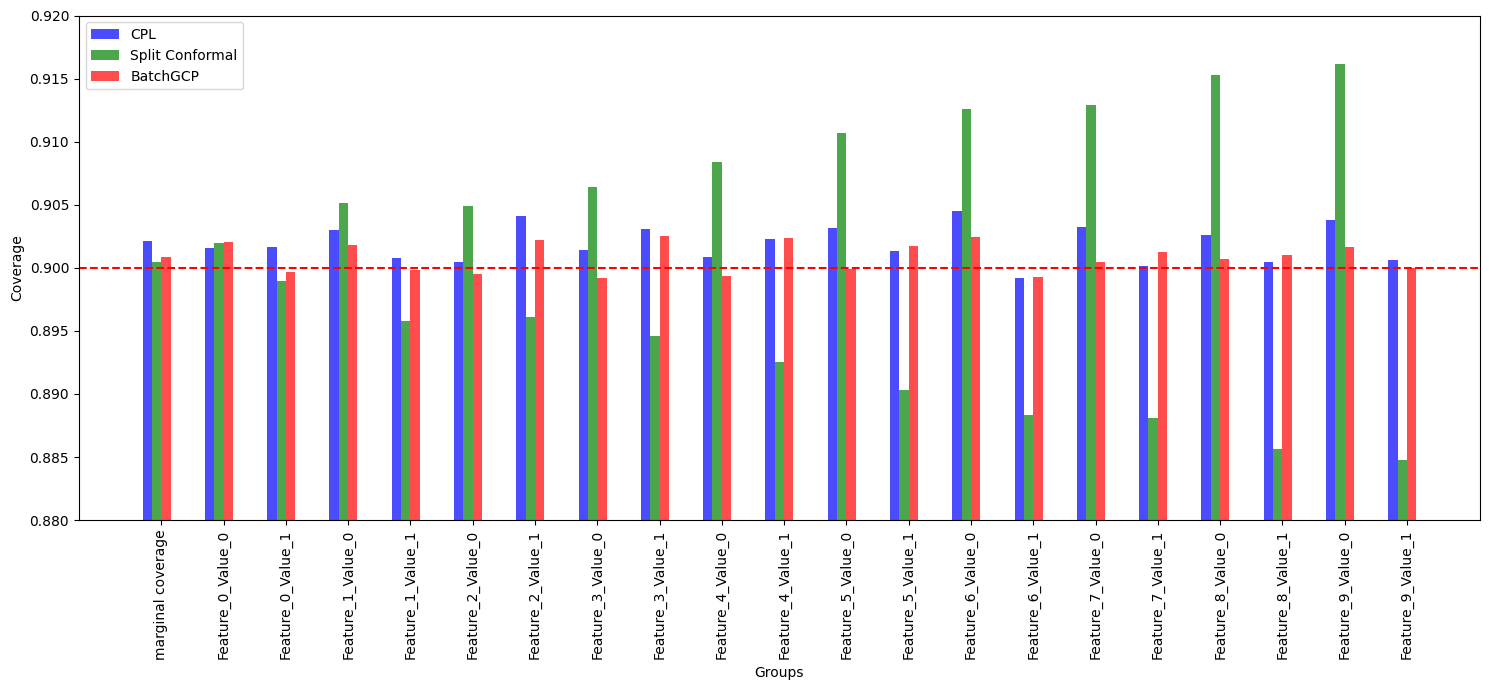

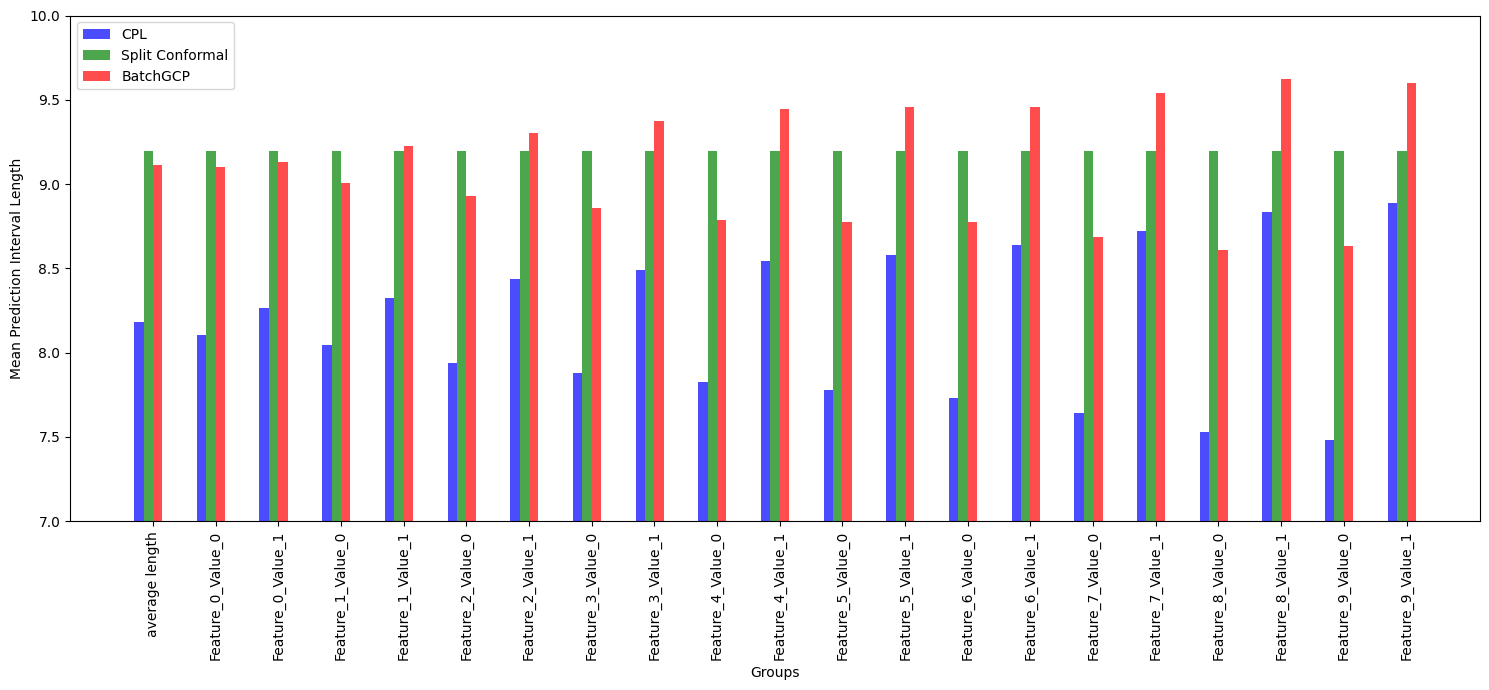

In [83]:
import matplotlib.pyplot as plt
device='cpu'
X_test = X_test.to(device)
S_test = S_test.to(device)
h = h.to(device)
def group_data_by_feature(X, S, binary_feature_idx):
    """
    Partition data based on the value of binary features.
    binary_feature_idx: indices of the binary features.
    """
    grouped_data = {}

    for idx in binary_feature_idx:
        for value in [0, 1]:  # binary feature can be 0 or 1
            mask = (X[:, idx] == value)
            grouped_data[f'Feature_{idx}_Value_{value}'] = (X[mask], S[mask])
    return grouped_data

def test_model_across_groups(X_test, y_test, binary_feature_idx):
    # Group the data by binary features
    groups = group_data_by_feature(X_test, S_test, binary_feature_idx)

    # Compute accuracy for each group
    accuracies1 = {}
    accuracies2 = {}
    accuracies3 = {}
    
    for group, (X_group, S_group) in groups.items():
        X_group, S_group = X_group.to(device), S_group.to(device)
        if len(X_group) > 0:  # Avoid groups with no samples
            with torch.no_grad():
                h_x_group = h(X_group).squeeze()
            condition = (S_group <= h_x_group).float()  
            accuracies1[group] = condition.mean().item()

            condition = (S_group <= q_HS).float()
            accuracies2[group] = condition.mean().item() 
            
            condition = (S_group <= torch.sum(theta_tensor * X_group[:, :theta_tensor.shape[0]] + theta_marginal, axis=1)).float()
            accuracies3[group] = condition.mean().item() 

    return accuracies1, accuracies2, accuracies3

def test_length_across_groups(X_test, y_test, binary_feature_idx):
    groups = group_data_by_feature(X_test, S_test, binary_feature_idx)
    
    length1 = {}
    length2 = {}
    length3 = {}
    
    for group, (X_group, S_group) in groups.items():
        X_group, S_group = X_group.to(device), S_group.to(device)
        if len(X_group) > 0:  # Avoid groups with no samples
            with torch.no_grad():
                h_x_group = h(X_group).squeeze()
            length1[group] = torch.clamp(h_x_group, min=0).mean().item()               

            length2[group] = q_HS
            
            length3[group] = torch.sum(theta_tensor * X_group[:, :theta_tensor.shape[0]] + theta_marginal, axis=1).mean().item() 

    return length1, length2, length3


def compare_models_plot(accuracies_model1, accuracies_model2, accuracies_model3):
   
    # Sorting groups for better visualization
    sorted_groups = ['marginal coverage'] + sorted(k for k in accuracies_model1 if k != 'marginal coverage')
    acc1 = [accuracies_model1[group] for group in sorted_groups]
    acc2 = [accuracies_model2[group] for group in sorted_groups]
    acc3 = [accuracies_model3[group] for group in sorted_groups]
    
    bar_width = 0.15
    index = range(len(sorted_groups))

    plt.figure(figsize=(15, 7))
    bar1 = plt.bar([i-1*bar_width for i in index], acc1, bar_width, label='CPL', color='b', alpha=0.7)
    bar2 = plt.bar(index, acc2, bar_width, label='Split Conformal', color='g', alpha=0.7)
    bar3 = plt.bar([i+1*bar_width for i in index], acc3, bar_width, label='BatchGCP', color='r', alpha=0.7)
    
    plt.axhline(0.9, color='red', linestyle='--')  # Drawing the baseline

    plt.ylim(0.88, 0.92)  # Set y-axis limits here

    plt.xlabel('Groups')
    plt.ylabel('Coverage')
    plt.xticks([i+bar_width/2 for i in index], sorted_groups, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()


def compare_length_plot(length_model1, length_model2, length_model3):
    
    # Sorting groups for better visualization, ensuring "average length" is first
    sorted_groups = ['average length'] + sorted(k for k in length_model1 if k != 'average length')
    acc1 = [length_model1[group] for group in sorted_groups]
    acc2 = [length_model2[group] for group in sorted_groups]
    acc3 = [length_model3[group] for group in sorted_groups]
    
    bar_width = 0.15
    index = range(len(sorted_groups))

    plt.figure(figsize=(15, 7))
    bar1 = plt.bar([i-1*bar_width for i in index], acc1, bar_width, label='CPL', color='b', alpha=0.7)
    bar2 = plt.bar(index, acc2, bar_width, label='Split Conformal', color='g', alpha=0.7)
    bar3 = plt.bar([i+1*bar_width for i in index], acc3, bar_width, label='BatchGCP', color='r', alpha=0.7)
    
    plt.axhline(0.9, color='red', linestyle='--')  # Drawing the baseline

    plt.ylim(7, 10)  # Set y-axis limits here

    plt.xlabel('Groups')
    plt.ylabel('Mean Prediction Interval Length')
    plt.xticks([i+bar_width/2 for i in index], sorted_groups, rotation=90)
    plt.legend()
    plt.tight_layout()
    plt.show()

binary_feature_idx = list(range(10))  # indices of the first 10 features as binary features
accuracies1, accuracies2, accuracies3 = test_model_across_groups(X_test, S_test, binary_feature_idx)
length1, length2, length3 = test_length_across_groups(X_test, S_test, binary_feature_idx)

with torch.no_grad():
    h_x_test = h(X_test).squeeze()
accuracies1['marginal coverage'] = (S_test <= h_x_test).float().mean().item()
accuracies2['marginal coverage'] = (S_test <= q_HS).float().mean().item()
accuracies3['marginal coverage'] = (S_test <= torch.sum(theta_tensor * X_test[:, :theta_tensor.shape[0]] + theta_marginal, axis=1)).float().mean().item()

with torch.no_grad():
    h_x_test = h(X_test).squeeze()
length1['average length'] = torch.clamp(h_x_test, min=0).mean().item() 
length2['average length'] = q_HS
length3['average length'] = torch.sum(theta_tensor * X_test[:, :theta_tensor.shape[0]] + theta_marginal, axis=1).mean().item()
    
    
compare_models_plot(accuracies1, accuracies2, accuracies3)
compare_length_plot(length1, length2, length3)